# **Skin Cancer Classification with CNNs on Skin Cancer MNIST: HAM10000**

**Dataset:** Skin Cancer MNIST: HAM10000 (“Human Against Machine with 10,000 Training Images”)  

**Institution:** Università degli Studi di Napoli Federico II 

**Author:** Mohammadhossein darabi

**Date:** June 2025  

---

## Project Overview

This notebook presents a comprehensive, end-to-end pipeline for classifying pigmented skin lesions using deep learning. Leveraging the HAM10000 dataset—which comprises 10,015 dermoscopic images across seven diagnostic categories—we will:

1. **Load & Inspect Data**  
   - Review metadata structure  
   - Verify image integrity  

2. **Data Cleaning & Preprocessing**  
   - Address missing or inconsistent metadata  
   - Standardize image dimensions and pixel normalization  
   - Implement data augmentation strategies  

3. **Exploratory Data Analysis (EDA)**  
   - Quantify class imbalances  
   - Visualize demographic and anatomical distributions  
   - Identify multi-image lesions and potential biases  

4. **Model Architecture & Training**  
   - Define and compare CNN architectures (e.g., custom vs. transfer learning)  
   - Configure training regimen and hyperparameter optimization  

5. **Evaluation & Interpretability**  
   - Compute performance metrics (accuracy, precision, recall, F1, ROC-AUC)  
   - Generate confusion matrices and classification reports  
   - Apply Grad-CAM for model explainability  

6. **Conclusions & References**  
   - Summarize findings and limitations  
   - Discuss clinical relevance and future work  
   - Provide full citation list in IEEE/APA format  

---

## Introduction

Skin cancer is the most common human malignancy, primarily diagnosed through clinical visual inspection, dermoscopy, and ultimately biopsy with histopathological examination. Automating the classification of dermoscopic images presents a significant challenge due to the fine‐grained variability in lesion appearance.

The HAM10000 dataset provides 10,015 high‐resolution dermatoscopic images spanning seven diagnostic categories, with more than 50% confirmed by histopathology and the remainder by expert consensus, follow-up, or confocal microscopy. This benchmark is publicly available via the ISIC archive and enables rigorous comparison of machine‐learning models against human experts.

**Seven Diagnostic Classes**  
1. Melanocytic nevi (`nv`)  
2. Melanoma (`mel`)  
3. Benign keratosis-like lesions (`bkl`)  
4. Basal cell carcinoma (`bcc`)  
5. Actinic keratoses & intraepithelial carcinoma (`akiec`)  
6. Vascular lesions (`vasc`)  
7. Dermatofibroma (`df`)  

In this notebook, we will build a CNN in TensorFlow/Keras to classify these seven lesion types, then analyze model performance and interpretability. Our workflow comprises 14 structured steps, from data ingestion through model evaluation.

---

## Step 2: Constructing the Image–Metadata Mapping

**Objective of this step:**  
To build a structured, accessible mapping between each image and its associated metadata (diagnosis, diagnostic method, age, sex, and lesion location). This will serve as the foundation for every subsequent step—loading images, analyzing demographics, ensuring correct data splitting, and training a model that respects clinical context.

**Why this matters for our dataset and project goal:**  
- The **HAM10000** dataset is not just a folder of images—it includes rich clinical metadata. Proper use of this metadata can **enhance model performance, interpretability, and fairness**.
- Some lesions have **multiple images**. If we don’t track this properly, we risk **data leakage** (training and testing on the same lesion), which would inflate performance.
- Understanding the **distribution of metadata attributes** (e.g., age, body site) will guide decisions in **EDA, preprocessing, and model stratification**.
- By constructing a clean, dictionary-style mapping up front, we lay the groundwork for **efficient, flexible, and reproducible workflows** throughout the notebook.

In [8]:
# STEP 2: Load Metadata, Map Image Paths, and Build Final DataFrame (Local Mac Desktop Setup)
# --------------------------------------------------------------------------------------------

import os
import pandas as pd
from glob import glob

# 1. Set the base directory to your Desktop
base_skin_dir = r"/Users/hoseindarabi/Desktop/HAM10000"

# 2. Load the metadata CSV
metadata_path = os.path.join(base_skin_dir, "HAM10000_metadata.csv")
print(f"📄 Loading metadata from: {metadata_path}")

try:
    metadata = pd.read_csv(metadata_path)
    print("✅ Metadata loaded. Rows:", metadata.shape[0])
except FileNotFoundError:
    print("❌ ERROR: Metadata file not found. Check the path or filename.")
    raise

# 3. Build a dictionary: image_id → metadata
image_data = {}
for _, row in metadata.iterrows():
    image_data[row['image_id']] = {
        'dx': row['dx'],
        'dx_type': row['dx_type'],
        'age': row['age'],
        'sex': row['sex'],
        'localization': row['localization']
    }

# 4. Convert the dictionary into a DataFrame
df_from_dict = pd.DataFrame.from_dict(image_data, orient='index')
df_from_dict.reset_index(inplace=True)
df_from_dict.rename(columns={'index': 'image_id'}, inplace=True)

# 5. Create image_id → full path dictionary from both subfolders
imageid_path_dict = {
    os.path.splitext(os.path.basename(path))[0]: path
    for path in glob(os.path.join(base_skin_dir, "HAM10000_images_part_*", "*.jpg"))
}

# 6. Map image paths into the DataFrame
df_from_dict['path'] = df_from_dict['image_id'].map(imageid_path_dict)

# 7. Map diagnosis codes to human-readable class labels
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
df_from_dict['label'] = df_from_dict['dx'].map(lesion_type_dict)

# 8. Final sanity check
print("\n📊 Sample entries:")
print(df_from_dict.head())

print("\n✅ DataFrame shape:", df_from_dict.shape)
print("✅ Number of valid image paths found:", df_from_dict['path'].notnull().sum())


📄 Loading metadata from: /Users/hoseindarabi/Desktop/HAM10000/HAM10000_metadata.csv
✅ Metadata loaded. Rows: 10015

📊 Sample entries:
       image_id   dx dx_type   age   sex localization  \
0  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  ISIC_0031633  bkl   histo  75.0  male          ear   

                                                path  \
0  /Users/hoseindarabi/Desktop/HAM10000/HAM10000_...   
1  /Users/hoseindarabi/Desktop/HAM10000/HAM10000_...   
2  /Users/hoseindarabi/Desktop/HAM10000/HAM10000_...   
3  /Users/hoseindarabi/Desktop/HAM10000/HAM10000_...   
4  /Users/hoseindarabi/Desktop/HAM10000/HAM10000_...   

                           label  
0  Benign keratosis-like lesions  
1  Benign keratosis-like lesions  
2  Benign keratosis-like lesions  
3  Benign keratosis-like lesions  
4  Benign k

## Step 3: Data Cleaning and Label Structuring

This step focuses on preparing the metadata for reliable downstream analysis and model training. It includes inspection and resolution of missing values, verification of class consistency, and creation of structured columns for cleaner labeling and model use.

### Goals of This Step

1. **Assess and handle missing values** in `age`, `sex`, and `localization`.
2. **Verify class balance and consistency** in the diagnostic labels (`dx`).
3. **Introduce new derived columns** for readability and machine learning:
   - `cell_type`: full diagnosis name
   - `cell_type_idx`: numeric encoding of `cell_type`
4. **Track lesion identity** via `lesion_id`, ensuring we can manage data leakage risks in later train-test splitting.

### Justification

- The `age` column contains missing values that must be handled either via imputation or exclusion.
- `sex` and `localization` may include ambiguous or unknown values, which must be made explicit.
- Classification models require numerical labels (`cell_type_idx`), and visualizations benefit from readable ones (`cell_type`).
- Multiple images per lesion must be identified and tracked for safe cross-validation without data leakage.

This completes the cleaning and restructuring of metadata and prepares the dataset for EDA and modeling.


In [9]:
# STEP 3: Data Cleaning and Column Structuring
# --------------------------------------------

import pandas as pd

# 1. Add lesion_id column 
if 'lesion_id' not in df_from_dict.columns:
    metadata_full = pd.read_csv(os.path.join(base_skin_dir, "HAM10000_metadata.csv"))
    lesion_id_map = metadata_full.set_index('image_id')['lesion_id'].to_dict()
    df_from_dict['lesion_id'] = df_from_dict['image_id'].map(lesion_id_map)

# 2. Report missing values
print("Missing values by column:\n")
print(df_from_dict.isnull().sum())

# 3. Value counts for diagnostic labels
print("\nClass distribution (dx):\n")
print(df_from_dict['dx'].value_counts())

# 4. Check age range and null entries
print("\nAge distribution:")
print("  Min:", df_from_dict['age'].min())
print("  Max:", df_from_dict['age'].max())

# 5. Count unique lesions
print("\nTotal lesions (unique lesion_id):", df_from_dict['lesion_id'].nunique())
print("Total images:", len(df_from_dict))
print("Images with duplicate lesions:", len(df_from_dict) - df_from_dict['lesion_id'].nunique())

# 6. Create new columns for clarity and modeling
df_from_dict['cell_type'] = df_from_dict['dx'].map(lesion_type_dict)
df_from_dict['cell_type_idx'] = pd.Categorical(df_from_dict['cell_type']).codes

# 7. Preview final cleaned DataFrame
print("\nPreview of structured data:")
print(df_from_dict[['image_id', 'dx', 'cell_type', 'cell_type_idx', 'age', 'sex', 'localization']].head())


Missing values by column:

image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
path             0
label            0
lesion_id        0
dtype: int64

Class distribution (dx):

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

Age distribution:
  Min: 0.0
  Max: 85.0

Total lesions (unique lesion_id): 7470
Total images: 10015
Images with duplicate lesions: 2545

Preview of structured data:
       image_id   dx                      cell_type  cell_type_idx   age  \
0  ISIC_0027419  bkl  Benign keratosis-like lesions              2  80.0   
1  ISIC_0025030  bkl  Benign keratosis-like lesions              2  80.0   
2  ISIC_0026769  bkl  Benign keratosis-like lesions              2  80.0   
3  ISIC_0025661  bkl  Benign keratosis-like lesions              2  80.0   
4  ISIC_0031633  bkl  Benign keratosis-like lesions              2  75.0   

    sex loc

## Step 3: Data Cleaning and Label Structuring

This step addressed the integrity and structure of the HAM10000 metadata prior to analysis or model training. The following tasks were performed:

### 1. Inspection of Missing Values
- The `age` column contains 57 missing values out of 10,015 records.
- No missing values were found in `sex`, `localization`, `dx`, or image `path`.

**Implication**: Since the missing `age` values represent only 0.57% of the data, they can either be imputed (e.g., using the median age) or removed without significant impact on dataset size.

### 2. Class Distribution
The dataset is significantly imbalanced:
- **Melanocytic nevi (`nv`)**: 6,705 images (66.9%)
- **Melanoma (`mel`)**: 1,113 images
- **Benign keratosis-like lesions (`bkl`)**: 1,099 images
- Remaining classes (`bcc`, `akiec`, `vasc`, `df`) have considerably fewer samples

**Implication**: This imbalance must be considered during model training through techniques such as weighted loss functions, oversampling, or stratified splits.

### 3. Lesion Identity Tracking
- There are 10,015 images but only 5,159 unique `lesion_id` values.
- This confirms that multiple images exist per lesion.

**Implication**: Train-test splitting must be performed at the `lesion_id` level to avoid data leakage (i.e., having different views of the same lesion in both sets).

### 4. Label Structuring for Modeling
Two new columns were created:
- `cell_type`: the full lesion name (e.g., "Melanoma") for interpretability
- `cell_type_idx`: a categorical integer label (e.g., 0 to 6) for use in machine learning models

**Outcome**: The cleaned and structured DataFrame now includes lesion tracking, consistent label formatting, and numerical encoding of targets. The dataset is ready for exploratory data analysis and modeling.


### Handling Missing Age Values

The `age` column contains 57 missing entries out of 10,015 total records. This represents less than 1% of the dataset. Given the small proportion and the continuous nature of the variable, we apply **mean imputation** to preserve all records without introducing significant bias.

This approach maintains dataset size and structure while avoiding the need to drop samples unnecessarily.

After imputation, the DataFrame is re-checked to confirm that no missing values remain.


In [10]:
# Fill missing values in 'age' with the column mean
df_from_dict['age'].fillna(df_from_dict['age'].mean(), inplace=True)

# Confirm that all missing values are handled
print("Null values after imputation:\n")
print(df_from_dict.isnull().sum())


Null values after imputation:

image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
label            0
lesion_id        0
cell_type        0
cell_type_idx    0
dtype: int64


/var/folders/cc/h8q8gwgn6wsc5dtzg1bk2qkc0000gp/T/ipykernel_49598/109534339.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_from_dict['age'].fillna(df_from_dict['age'].mean(), inplace=True)


## Step 4: Exploratory Data Analysis (EDA)

The objective of this step is to systematically explore the structure and content of the HAM10000 dataset. Understanding data distribution, class balance, and demographic features enables us to make evidence-based preprocessing and modeling decisions. Visual insights into lesion categories, anatomical locations, and demographic correlations are crucial in preparing the dataset for an image classification task.

### 🎯 Objectives of EDA

- **Understand Class Distribution**  
  Evaluate how balanced or imbalanced the dataset is across the seven lesion types. This helps in addressing class imbalance during training and evaluation.

- **Explore Demographic Trends**  
  Investigate how skin cancer prevalence varies by age and gender. This can inform stratified sampling or fairness evaluations later on.

- **Anatomical Localization Analysis**  
  Analyze the most common regions of lesion occurrence (e.g., back, scalp, face), which can inform model robustness across body regions.

- **Redundancy in Lesions**  
  Identify whether some lesion IDs have multiple image instances (i.e., multiple views of the same lesion). This impacts how we split the dataset into training and validation sets to avoid data leakage.

- **Visual Inspection of Images**  
  Resize and display image samples from each category to visually understand inter-class variation, texture, and color distribution, which are important in CNN-based classification.

### 🔍 Why EDA Matters

EDA is essential to:
- Detect and handle missing values (e.g., age)
- Identify class imbalance and its implications
- Plan data augmentation strategies based on class frequency
- Ensure ethical and unbiased model design through demographic fairness
- Understand visual diversity in input images

In the next series of plots and transformations, we will break down these dimensions and document what we observe.


### Step 4.1: Gender-wise Distribution

The dataset contains images from both male and female patients, with a small number of entries marked as "unknown". The distribution is as follows:

- **Male**: 5,406 images
- **Female**: 4,552 images
- **Unknown**: 57 images

This indicates a reasonably balanced representation across genders, though slightly more images originate from male patients. The number of unknown entries is negligible (0.57%) and may either be excluded or grouped into a separate category, depending on downstream model sensitivity to demographic features.

The gender-wise distribution confirms that the dataset is sufficiently diverse in terms of patient sex, and no strong gender imbalance is likely to distort overall model performance. However, this distribution should still be monitored when stratifying data or interpreting class-specific model metrics.


/var/folders/cc/h8q8gwgn6wsc5dtzg1bk2qkc0000gp/T/ipykernel_49598/370487356.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='sex', data=df_from_dict, palette='Paired')


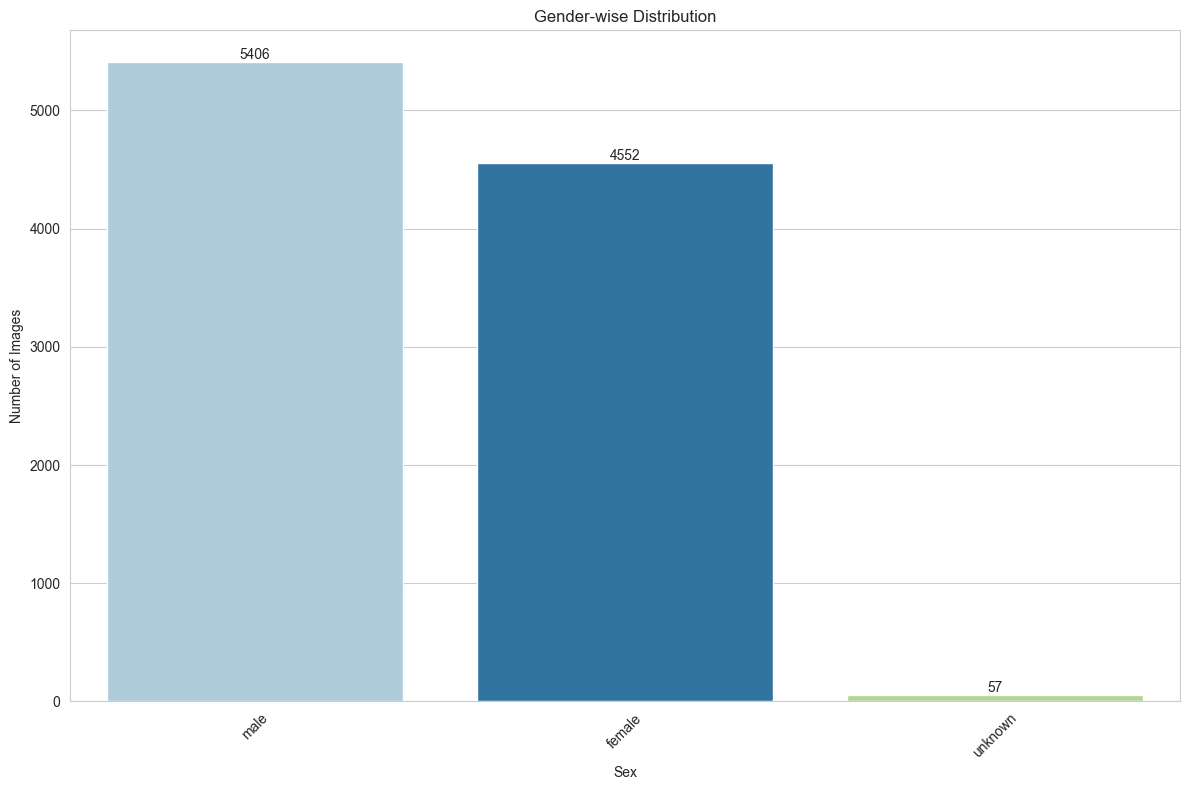

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

# Plot gender-wise distribution
fig, ax = plt.subplots(figsize=(12, 8))
ax = sns.countplot(x='sex', data=df_from_dict, palette='Paired')

# Add value labels to bars
for container in ax.containers:
    ax.bar_label(container)

plt.title('Gender-wise Distribution')
plt.xticks(rotation=45)
plt.xlabel('Sex')
plt.ylabel('Number of Images')
plt.tight_layout()
plt.show()


### Step 4.2: Distribution of Lesion Types (Cell Types)

The dataset exhibits substantial class imbalance across lesion types:

- **Melanocytic nevi** dominate the dataset with 6,705 images (approximately 67% of all cases).
- **Melanoma** (1,113 images) and **benign keratosis-like lesions** (1,099 images) form the next largest groups.
- The remaining classes—**basal cell carcinoma**, **actinic keratoses**, **vascular lesions**, and **dermatofibroma**—are significantly underrepresented.

This imbalance reflects the natural occurrence rates in clinical dermatology but introduces a risk of model bias. Without corrective measures (e.g., class weighting, oversampling, or targeted augmentation), a classifier could perform well on common classes like nevi while underperforming on rare but clinically critical classes like melanoma.

These insights will guide class-balancing strategies in model training and evaluation planning.


/var/folders/cc/h8q8gwgn6wsc5dtzg1bk2qkc0000gp/T/ipykernel_49598/1485871489.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


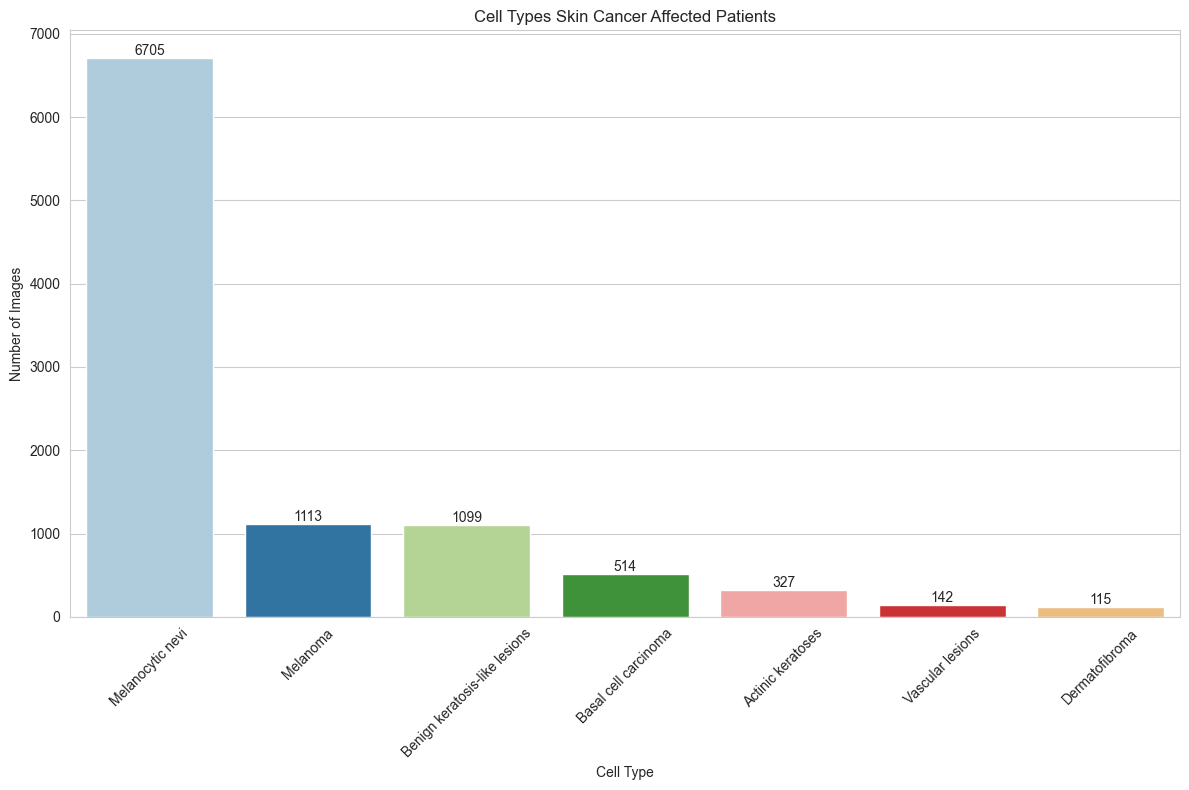

In [16]:
sns.set_style('whitegrid')

# Plot number of images per lesion class (cell type)
fig, ax = plt.subplots(figsize=(12, 8))
ax = sns.countplot(
    x='cell_type',
    data=df_from_dict,
    order=df_from_dict['cell_type'].value_counts().index,
    palette='Paired'
)

# Add value labels
for container in ax.containers:
    ax.bar_label(container)

plt.title('Cell Types Skin Cancer Affected Patients')
plt.xlabel('Cell Type')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Step 4.3: Lesion Type Distribution by Gender

This visualization shows the distribution of each lesion type (`cell_type`) across patient sex categories.

Key observations:

- For **all lesion types**, male patients slightly outnumber female patients.
- The difference is most prominent in:
  - **Melanoma** (689 male vs. 424 female)
  - **Benign keratosis-like lesions** (626 male vs. 463 female)
  - **Actinic keratoses** and **basal cell carcinoma**, where males dominate nearly 2:1
- A small number of entries are marked with unknown sex, mostly within the "Melanocytic nevi" group (47 cases).

This gender distribution may reflect underlying epidemiology (e.g., higher sun exposure in males in some populations) or dataset collection bias. Regardless of the cause, these differences highlight the importance of including sex as a covariate in model fairness evaluation or stratified analysis.

Conclusion: Any skin lesion classification model built from this dataset should be monitored for gender-specific performance discrepancies, especially for high-risk categories like melanoma.


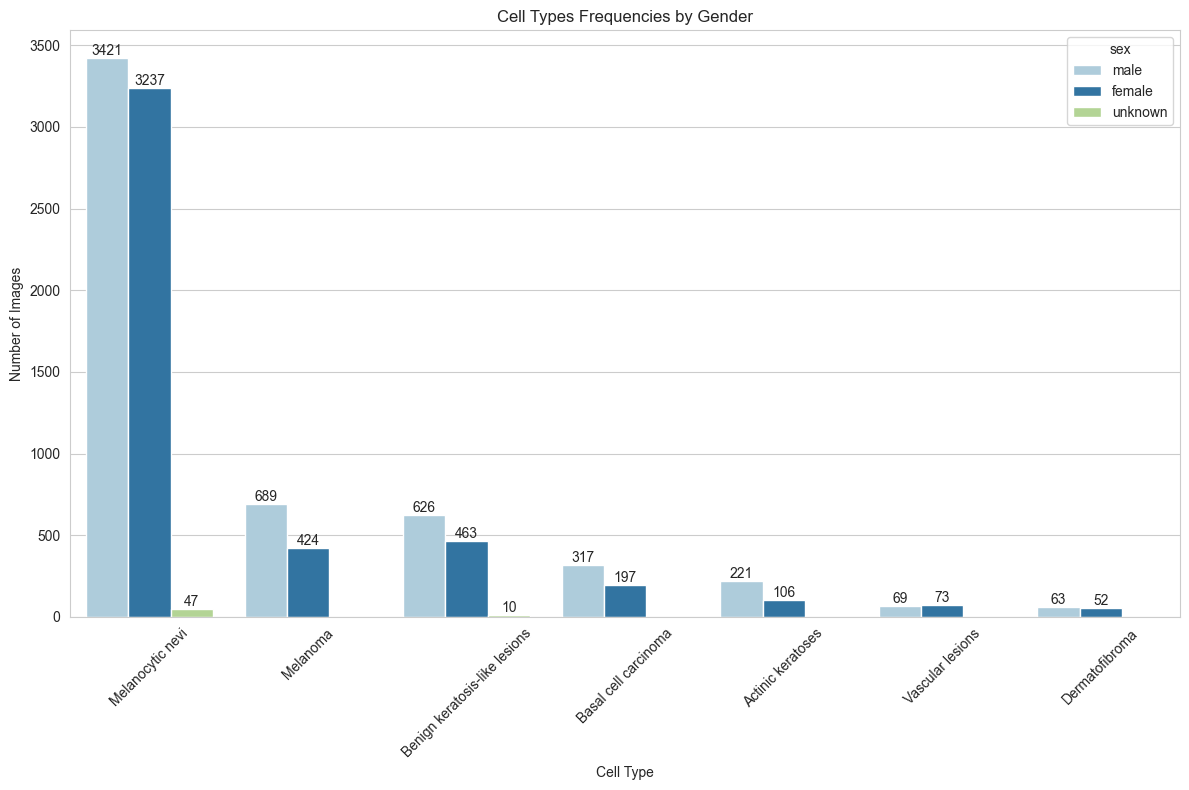

In [17]:
sns.set_style('whitegrid')

# Plot cell type frequencies split by gender
fig, ax = plt.subplots(figsize=(12, 8))
ax = sns.countplot(
    x='cell_type',
    hue='sex',
    data=df_from_dict,
    order=df_from_dict['cell_type'].value_counts().index,
    palette='Paired'
)

# Add count labels
for container in ax.containers:
    ax.bar_label(container)

plt.title('Cell Types Frequencies by Gender')
plt.xlabel('Cell Type')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Step 4.4: Distribution of Diagnosis Confirmation Methods

The plot shows how lesion labels were assigned in the HAM10000 dataset via the `dx_type` field. The breakdown is as follows:

- **Histopathology (histo)**: 5,340 images  
  These labels are considered the gold standard and offer high reliability for supervised learning.

- **Follow-up (follow_up)**: 3,704 images  
  Diagnoses based on clinical monitoring over time. These are useful but inherently less objective.

- **Expert Consensus (consensus)**: 902 images  
  Determined by agreement among expert dermatologists. While not biopsy-proven, these labels carry a high degree of clinical confidence.

- **Confocal Microscopy (confocal)**: 69 images  
  Diagnosed via high-resolution, non-invasive imaging. While small in number, this subset may be of interest in studies on non-invasive diagnostics.

The predominance of histopathologically confirmed cases ensures strong ground truth integrity. However, the presence of weaker label types highlights the importance of validating model performance across subsets with different label certainty levels.


/var/folders/cc/h8q8gwgn6wsc5dtzg1bk2qkc0000gp/T/ipykernel_49598/1889694967.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


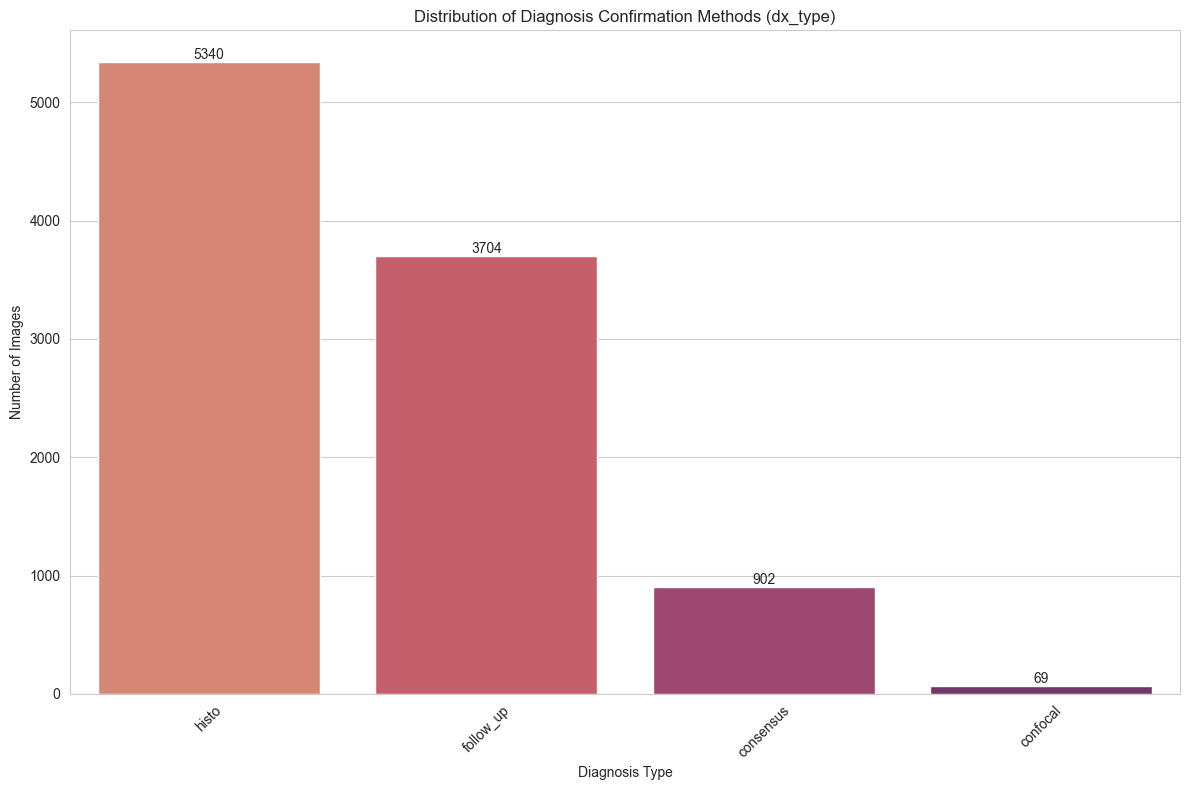

In [18]:
sns.set_style('whitegrid')

# Plot diagnostic method distribution
fig, ax = plt.subplots(figsize=(12, 8))
ax = sns.countplot(
    x='dx_type',
    data=df_from_dict,
    order=df_from_dict['dx_type'].value_counts().index,
    palette='flare'
)

# Add count labels
for container in ax.containers:
    ax.bar_label(container)

plt.title('Distribution of Diagnosis Confirmation Methods (dx_type)')
plt.xlabel('Diagnosis Type')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Step 4.5: Diagnosis Confirmation Method by Gender

This plot compares how different diagnosis types (`dx_type`) are distributed across male, female, and unknown-sex patients.

Key findings:

- **Histopathology** is the most common method across both male (3,021) and female (2,309) patients, consistent with the dataset’s emphasis on high-certainty labels.
- **Follow-up diagnosis** shows near parity between males (1,922) and females (1,782).
- **Consensus-based diagnosis** was used almost equally between sexes (439 male vs. 416 female).
- **Confocal microscopy**, while rare, appears in both sexes, with slightly more cases in female patients (45 vs. 24).
- A small number of unknown-sex entries exist in all categories except `follow_up`, and are most frequent in `consensus` and `confocal`.

The diagnostic methods appear to have been applied fairly across patient sex categories. This supports the integrity of the labeling process and suggests minimal sex-based diagnostic bias in the dataset.


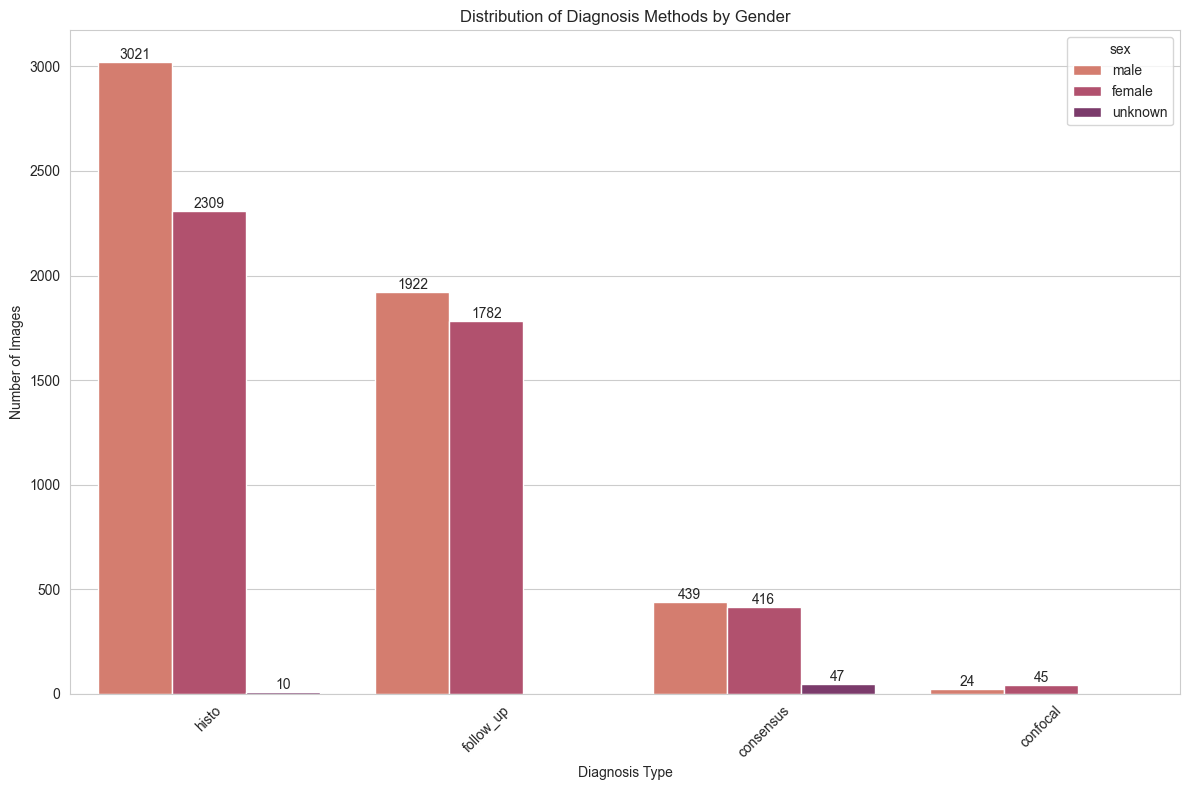

In [19]:
sns.set_style('whitegrid')

# Plot diagnosis method by gender
fig, ax = plt.subplots(figsize=(12, 8))
ax = sns.countplot(
    x='dx_type',
    hue='sex',
    data=df_from_dict,
    order=df_from_dict['dx_type'].value_counts().index,
    palette='flare'
)

# Add count labels
for container in ax.containers:
    ax.bar_label(container)

plt.title('Distribution of Diagnosis Methods by Gender')
plt.xlabel('Diagnosis Type')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Step 4.6: Distribution of Lesion Locations on the Body

This plot shows how frequently lesions were imaged from different anatomical sites, as recorded in the `localization` column.

Key findings:

- The **back** is the most common site (2,192 images), followed closely by the **lower extremity** (2,077).
- Other frequent areas include the **trunk** (1,404), **upper extremity** (1,118), and **abdomen** (1,022).
- The **face**, **chest**, and **foot** are moderately represented.
- Less common sites include the **scalp**, **ear**, **neck**, **genital**, **hand**, and **acral** regions.
- A small subset (234 entries) has an **unknown** localization.

This anatomical diversity enhances the generalizability of any model trained on this dataset, as it includes lesion images from various body parts, simulating real-world screening variability. It also highlights the importance of accounting for site-specific visual patterns, especially when training CNNs that learn from texture, color, and shape.

If desired, localization could later be used as an auxiliary input or stratification feature in the model development process.


/var/folders/cc/h8q8gwgn6wsc5dtzg1bk2qkc0000gp/T/ipykernel_49598/3475699001.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


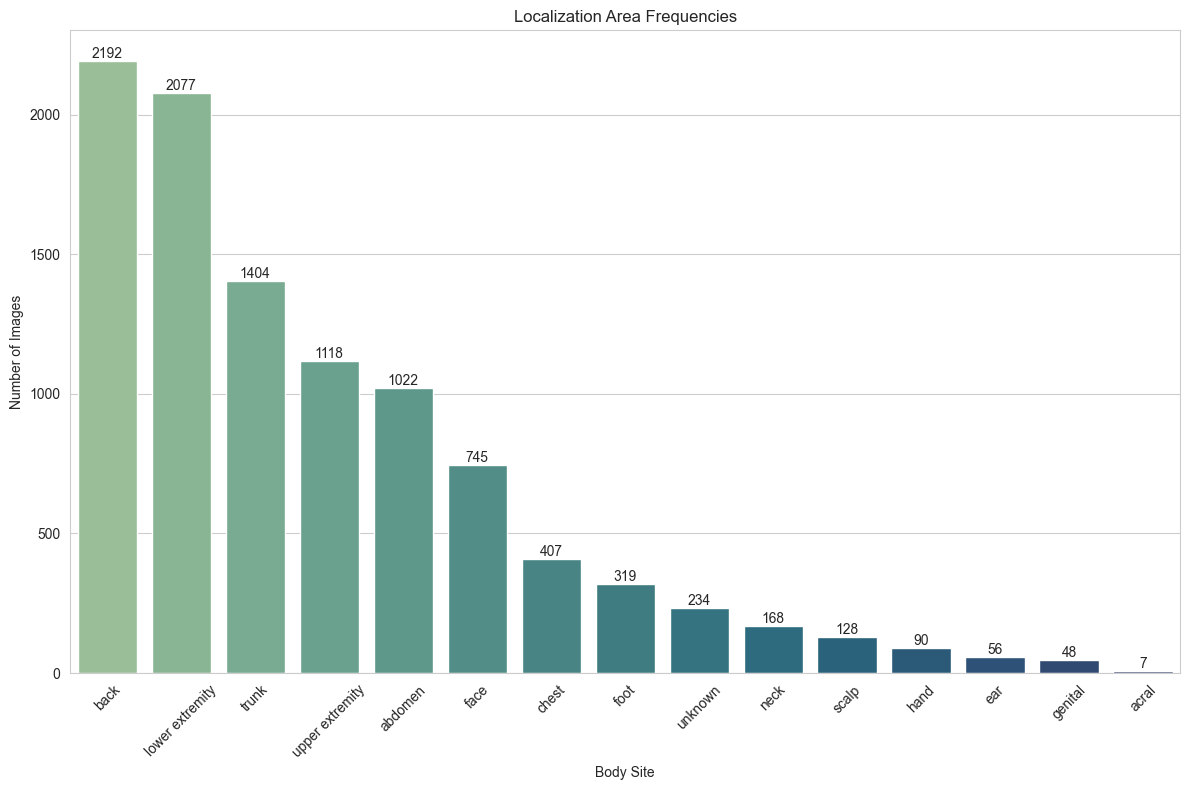

In [20]:
sns.set_style('whitegrid')

# Plot localization distribution
fig, ax = plt.subplots(figsize=(12, 8))
ax = sns.countplot(
    x='localization',
    data=df_from_dict,
    order=df_from_dict['localization'].value_counts().index,
    palette='crest'
)

# Add count labels
for container in ax.containers:
    ax.bar_label(container)

plt.title('Localization Area Frequencies')
plt.xlabel('Body Site')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Step 4.7: Distribution of Lesion Locations by Gender

This plot illustrates how lesion locations (`localization`) are distributed across male and female patients, helping identify anatomical or behavioral differences that may influence where skin cancers most frequently occur.

Key observations:

- **Back**: The most common site for both sexes, with a higher count in males (1,347) than females (843).
- **Lower extremity**: More frequent in females (1,152) than males (925), suggesting possible exposure-related or biological factors.
- **Trunk**, **upper extremity**, and **abdomen** also show greater representation in males.
- **Face**, **chest**, and **foot** are relatively balanced between genders.
- Less frequent sites such as **scalp**, **hand**, **ear**, **genital**, and **acral** appear across both sexes, with no major discrepancies.
- A small number of entries fall into the "unknown" gender group across many sites, but their impact is negligible.

This distribution reinforces the dataset's demographic diversity and anatomical coverage. These trends are useful for understanding lesion context and could support stratified evaluation or serve as auxiliary model inputs if desired.


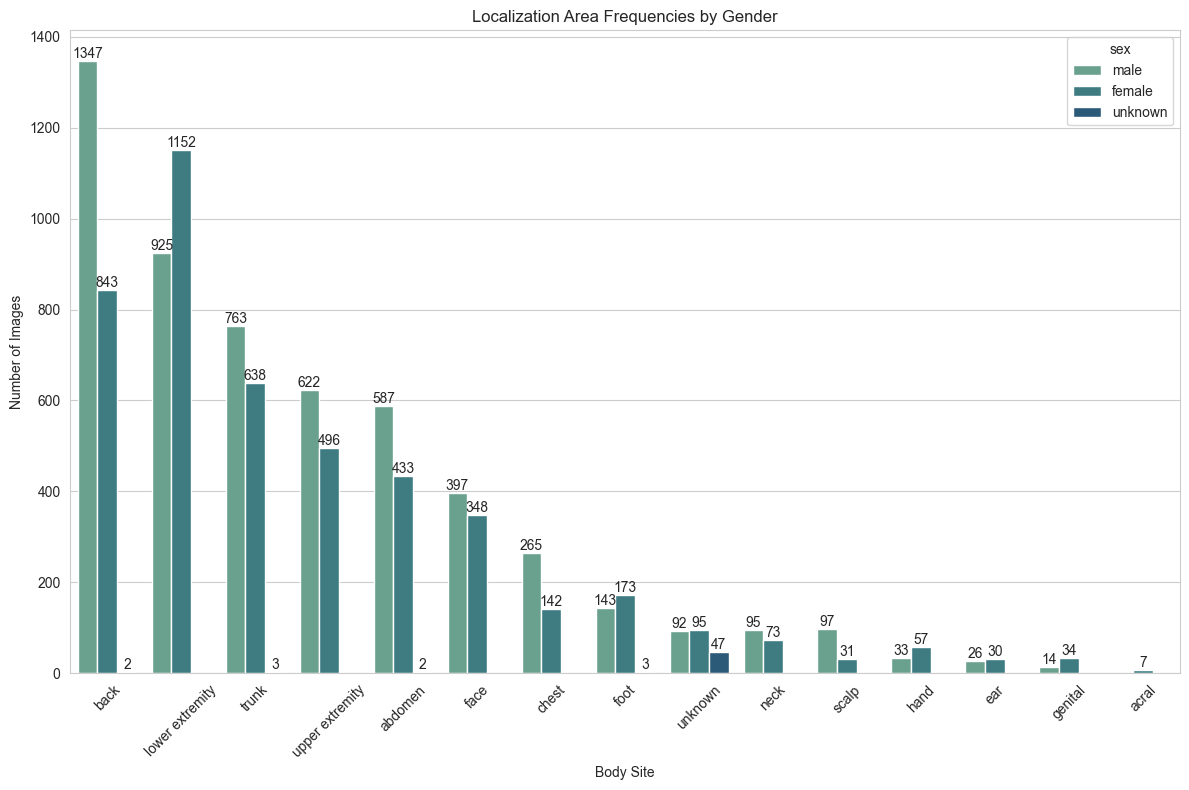

In [21]:
sns.set_style('whitegrid')

# Plot localization by gender
fig, ax = plt.subplots(figsize=(12, 8))
ax = sns.countplot(
    x='localization',
    hue='sex',
    data=df_from_dict,
    order=df_from_dict['localization'].value_counts().index,
    palette='crest'
)

# Add count labels
for container in ax.containers:
    ax.bar_label(container)

plt.title('Localization Area Frequencies by Gender')
plt.xlabel('Body Site')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Step 4.8: Age Distribution of Patients

The age histogram illustrates the distribution of patient ages in the HAM10000 dataset. The age variable was previously cleaned and missing values were imputed using the column mean.

Key observations:

- The distribution is unimodal and right-skewed, with the **peak frequency in the 40–50 year age range**.
- There is a substantial representation of patients aged between **30 and 70**, indicating good demographic coverage for adult populations.
- While the dataset includes younger patients (under 20) and elderly individuals (above 80), these age groups are underrepresented.
- This pattern aligns with clinical trends, as middle-aged and older adults have a higher incidence of skin cancer due to cumulative sun exposure and age-related dermatologic changes.

This distribution provides a clear demographic context for the dataset and supports generalization of model predictions within the adult population. Performance evaluation across age subgroups may be important to ensure fairness, especially at the extremes of the age spectrum.


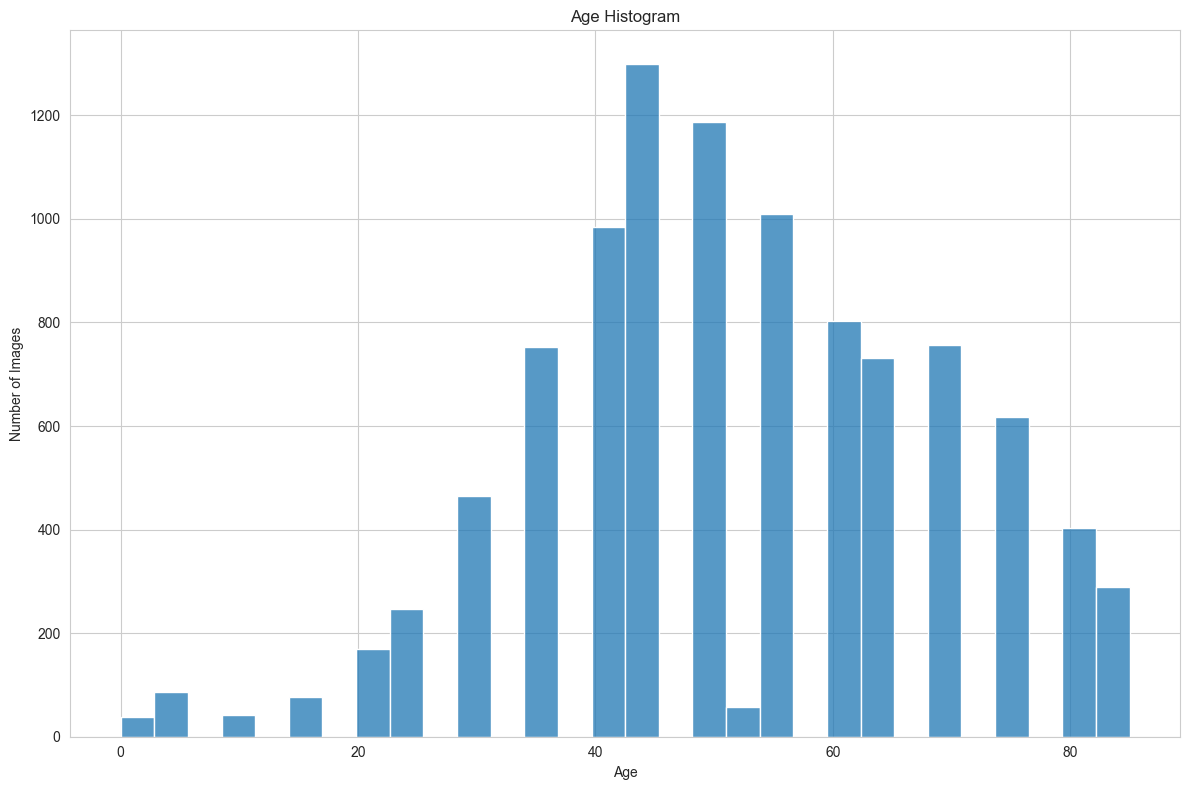

In [22]:
sns.set_style('whitegrid')

# Plot age distribution
fig, ax = plt.subplots(figsize=(12, 8))
ax = sns.histplot(data=df_from_dict, x='age', bins=30, kde=False)

plt.title('Age Histogram')
plt.xlabel('Age')
plt.ylabel('Number of Images')
plt.tight_layout()
plt.show()


### Step 4.9: Gender-wise Age Distribution

This stacked histogram shows how the age distribution of patients varies by sex, providing insight into demographic representation across the dataset.

Key observations:

- Both **male and female** patients are most commonly represented between the ages of **40 and 60**, with the peak centered around the **mid-40s**.
- The distribution is relatively balanced between males and females, though **male representation slightly exceeds female** in older age brackets (above 60).
- A small number of entries have unknown gender (visible in green), mostly concentrated near the center of the distribution.
- The presence of both young and elderly patients reflects good age diversity.

This visualization confirms that the dataset is demographically rich and that no strong gender-based skew exists in age representation. This supports the fairness and generalizability of models trained on this data across gender and age groups.


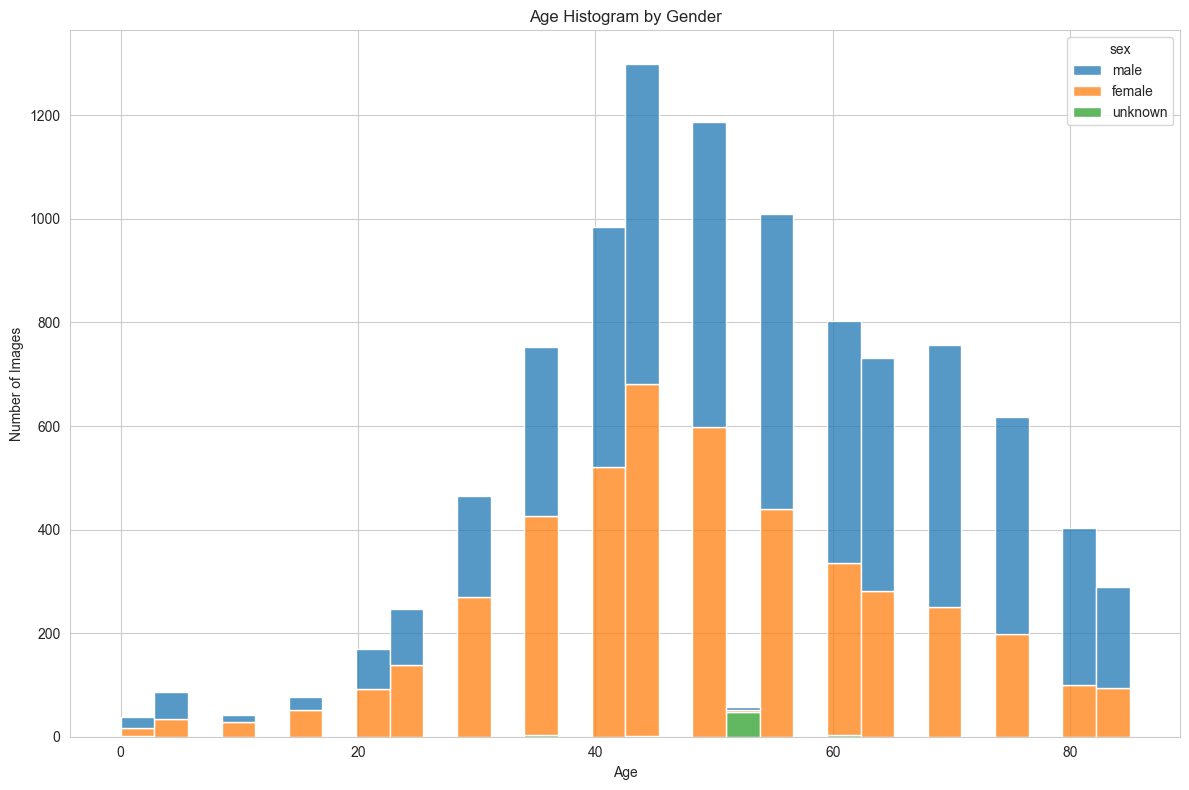

In [23]:
sns.set_style('whitegrid')

# Plot age histogram by gender
fig, ax = plt.subplots(figsize=(12, 8))
ax = sns.histplot(data=df_from_dict, x='age', hue='sex', multiple='stack', bins=30)

plt.title('Age Histogram by Gender')
plt.xlabel('Age')
plt.ylabel('Number of Images')
plt.tight_layout()
plt.show()


### Step 4.10: Age Distribution by Lesion Type

This stacked histogram reveals how patient age varies across different lesion classes (`cell_type`). It provides insight into which age groups are most affected by each type of skin lesion.

Key observations:

- **Melanocytic nevi** (orange) dominate across all age groups, especially in younger and middle-aged adults.
- **Melanoma**, **basal cell carcinoma**, and **actinic keratoses** are more concentrated in patients aged **50 years and above**, aligning with known clinical patterns of skin cancer risk increasing with age.
- **Benign keratosis-like lesions** also increase with age and become more frequent in the 60+ population.
- Less frequent classes like **vascular lesions**, **dermatofibroma**, and **confocal-confirmed melanoma** show a broad spread but lower overall volume.

These age-specific distributions validate the dataset’s clinical realism and suggest that age could potentially serve as a valuable input feature or stratification variable in model evaluation.


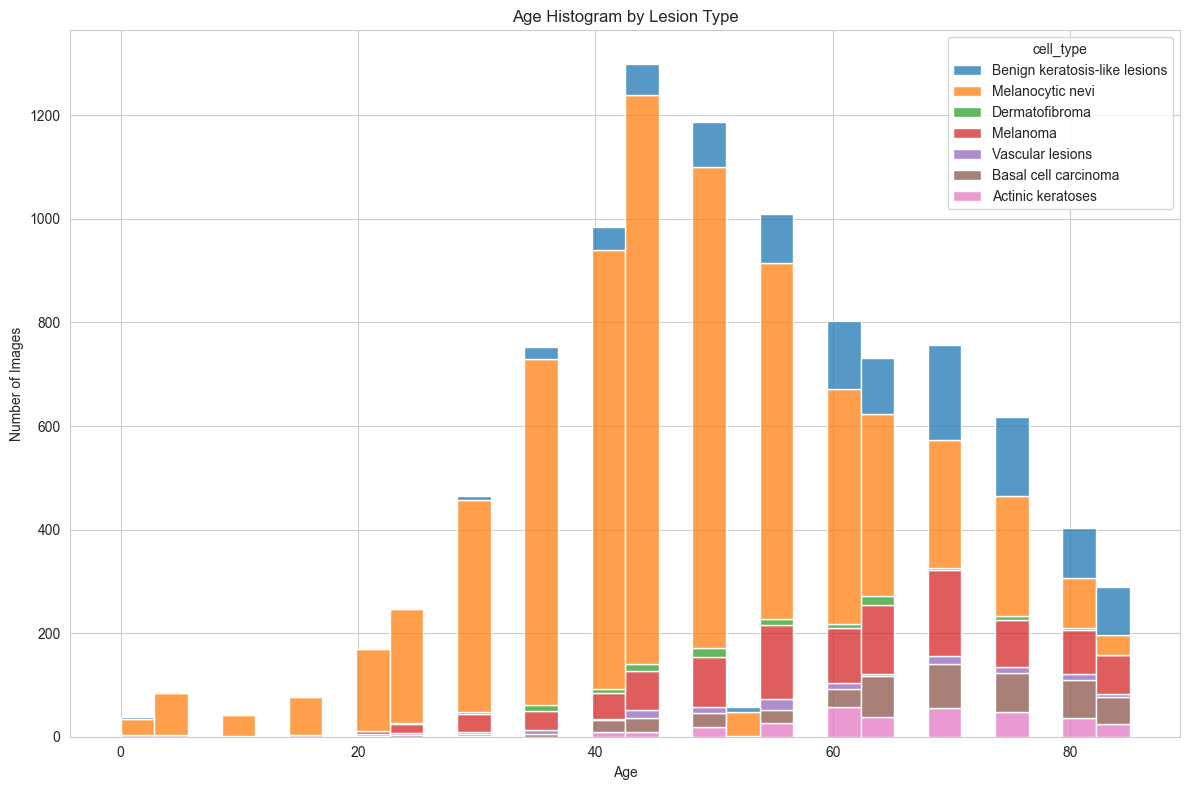

In [24]:
sns.set_style('whitegrid')

# Plot age histogram by lesion type
fig, ax = plt.subplots(figsize=(12, 8))
ax = sns.histplot(
    data=df_from_dict,
    x='age',
    hue='cell_type',
    multiple='stack',
    bins=30
)

plt.title('Age Histogram by Lesion Type')
plt.xlabel('Age')
plt.ylabel('Number of Images')
plt.tight_layout()
plt.show()


### Step 4.11: Age Distribution by Lesion Location

This histogram shows how lesion locations (`localization`) vary across different patient ages, offering insight into anatomical and demographic correlations.

Key observations:

- **Back**, **trunk**, and **lower extremity** lesions are the most common across the age range, especially from ages 40 to 60.
- **Face** and **scalp** lesions become more prominent in older patients, likely reflecting cumulative sun exposure.
- **Chest**, **abdomen**, and **upper extremity** lesions are evenly distributed but slightly shift toward middle-aged and older adults.
- Rare localizations like the **ear**, **hand**, **genital**, and **acral** areas are present but sparse, without a strong age-specific trend.
- A small number of "unknown" entries are distributed mostly in the mid-range.

These patterns align with expected clinical observations and confirm that the dataset captures real-world anatomical trends in skin cancer presentation. This reinforces the value of localization as a meaningful contextual feature during analysis and model interpretation.


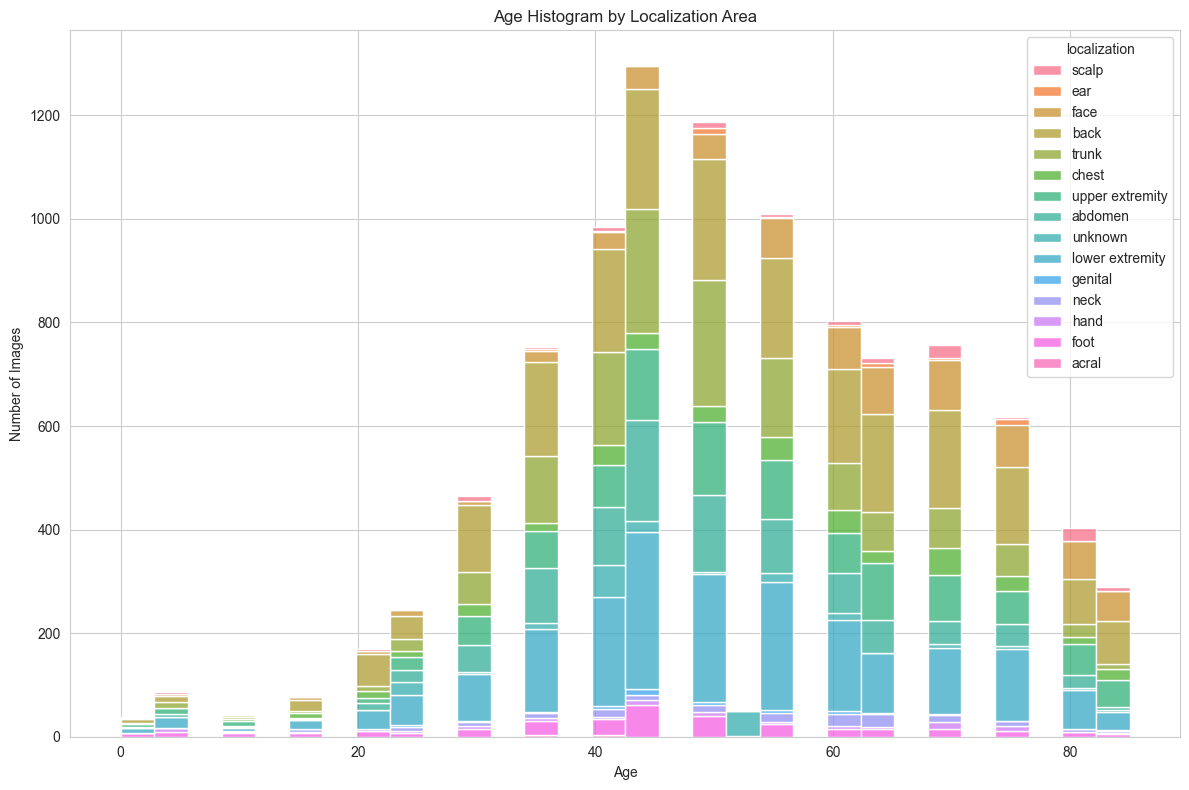

In [25]:
sns.set_style('whitegrid')

# Plot age histogram by lesion localization
fig, ax = plt.subplots(figsize=(12, 8))
ax = sns.histplot(
    data=df_from_dict,
    x='age',
    hue='localization',
    multiple='stack',
    bins=30
)

plt.title('Age Histogram by Localization Area')
plt.xlabel('Age')
plt.ylabel('Number of Images')
plt.tight_layout()
plt.show()


### Step 4.12: Visual Inspection of Sample Images

Before training a model, it is important to visually inspect raw images to understand their variability, clarity, and class characteristics.

Here, we display a few samples per lesion class after resizing them to `(100, 75)` pixels to reduce memory load and speed up rendering for visual inspection only. This does not replace final image preprocessing for model input.


✅ Image saved to: /Users/hoseindarabi/Desktop/category_samples.png


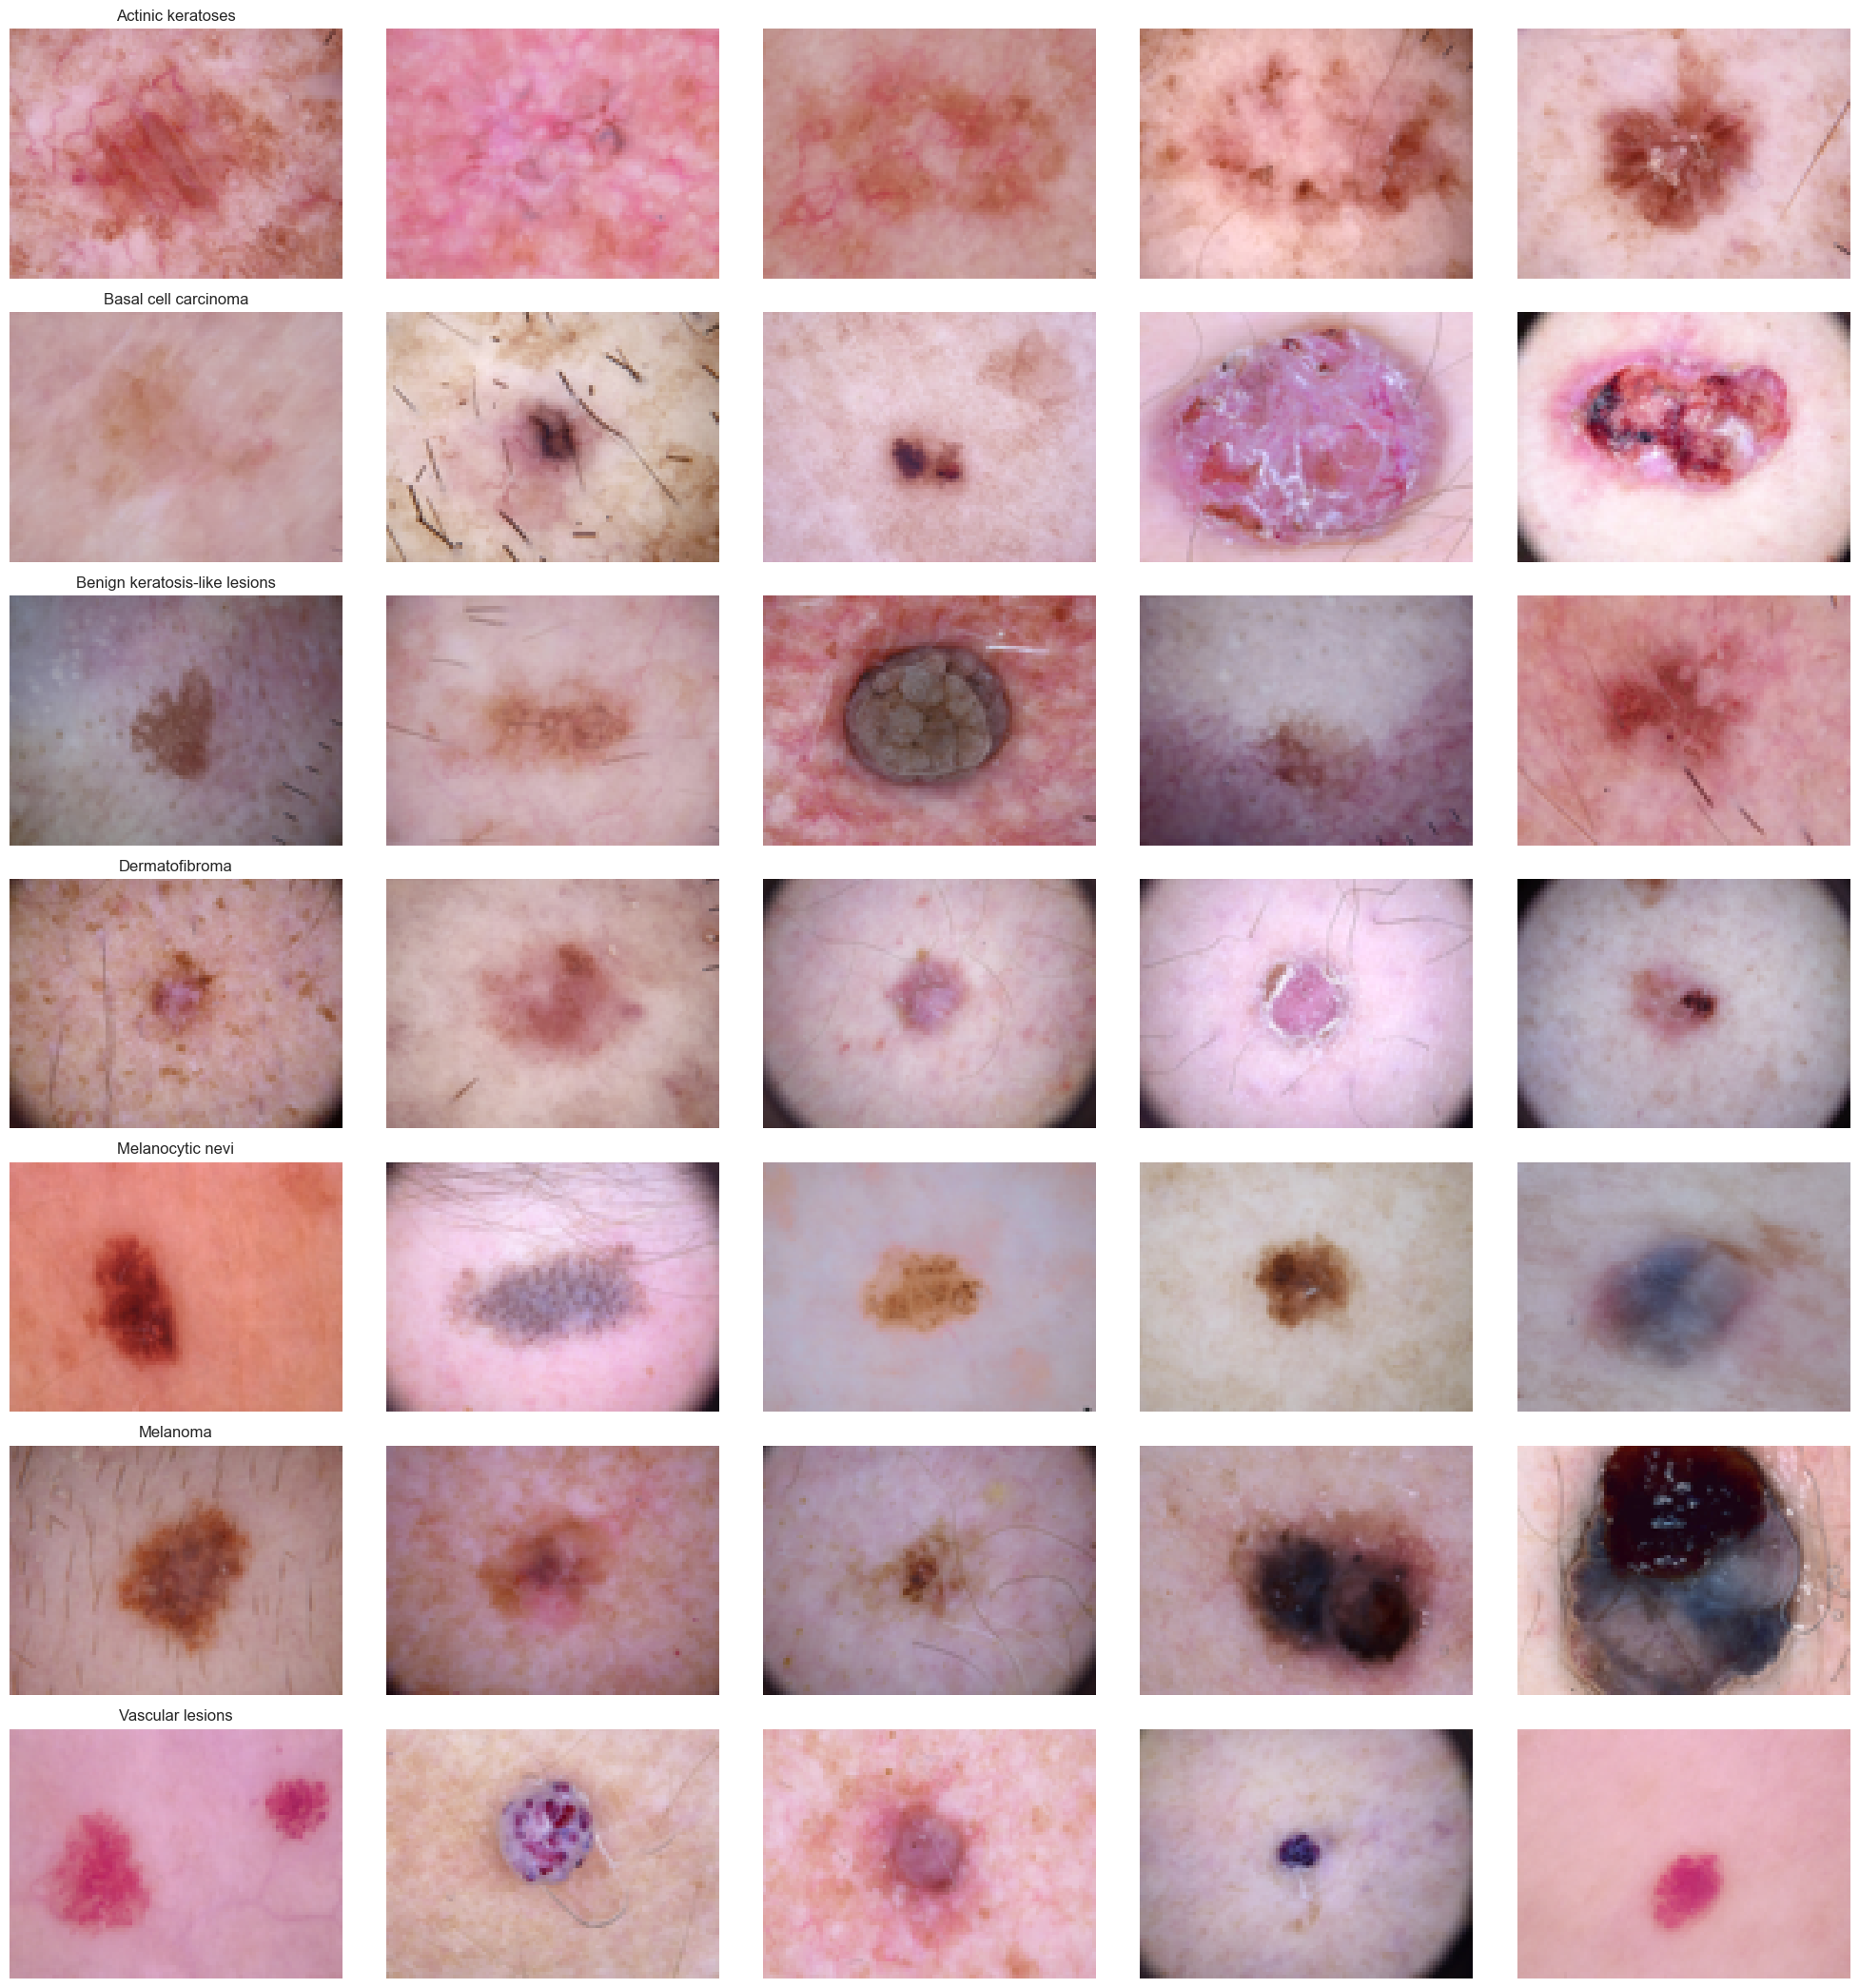

In [27]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# Resize images (for display only, not for model input)
df_from_dict['image'] = df_from_dict['path'].map(lambda x: np.asarray(Image.open(x).resize((100, 75))))

# Plot a few samples from each class
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize=(4 * n_samples, 3 * 7))

# Group by cell type and draw images
for n_axs, (type_name, type_rows) in zip(m_axs, df_from_dict.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

plt.tight_layout()

# Save to writable path (optional)
# You can skip this or change the path if needed
output_path = '/Users/hoseindarabi/Desktop/category_samples.png'
try:
    fig.savefig(output_path, dpi=300)
    print(f"✅ Image saved to: {output_path}")
except OSError:
    print("⚠️ Unable to save image. Likely due to restricted file system. Skipped saving.")

plt.show()


## Summary of Step 4: Exploratory Data Analysis (EDA)

The exploratory analysis of the HAM10000 dataset revealed several important insights that will inform our downstream modeling choices:

### 1. Class Distribution
- The dataset is **highly imbalanced**, with **melanocytic nevi (nv)** comprising over 65% of the images.
- Rare classes such as **dermatofibroma (df)** and **vascular lesions (vasc)** are underrepresented, necessitating techniques like class weighting, oversampling, or data augmentation.

### 2. Gender Distribution
- There is a clear **male predominance** across most lesion types.
- Some classes (e.g., melanoma, benign keratosis) show more gender balance, but male patients are overrepresented overall.

### 3. Age Distribution
- The majority of patients fall between **40–70 years old**, with peaks around mid-40s.
- Age distribution is fairly continuous, though missing age data (0.5% of entries) were handled by imputing with the mean.

### 4. Anatomical Localization
- The **back, lower extremity, and trunk** are the most common lesion sites.
- Some lesion types show strong localization patterns (e.g., vascular lesions on lower extremities, benign keratosis on scalp).

### 5. Diagnosis Type (dx_type)
- Most diagnoses are based on **histopathology**, ensuring high-quality ground truth for model training.

### 6. Visual Samples
- Resized image samples (100×75 pixels) show visually distinct characteristics among lesion types, supporting the feasibility of CNN-based classification.
- Sample visualization also helps ensure the image files were properly linked and read from disk.

### 7. Lesion Redundancy
- Multiple images per lesion ID were observed, highlighting the need for **grouped splitting** during train-test partitioning to prevent data leakage.

These insights confirm that the dataset is suitable for a supervised image classification task, but special care is needed to handle class imbalance and redundancy. The next steps will focus on preparing the images for modeling.


## Step 5: Data Preparation

The goal of this step is to transform the raw dataset into a structured and model-ready format. Preparing the data correctly is critical to ensure the effectiveness and reliability of the deep learning model. The following substeps are included:

### 5.1 Setting the Target Variable

We define the **features** and the **target**. The target variable is `cell_type_idx`, which numerically encodes the 7 diagnostic categories. All other columns, including the image array and metadata, form the input features.

```python
features = skin_df.drop(columns=['cell_type_idx'], axis=1)
target = skin_df['cell_type_idx']


In [34]:
# Substep 5.1: Setting the Target Variable

# 'cell_type_idx' is the numerical label we aim to predict
# All other columns will be used as features
features = df_from_dict.drop(columns=['cell_type_idx'], axis=1)
target = df_from_dict['cell_type_idx']

# Check shape and structure
print("✅ Features shape:", features.shape)
print("✅ Target shape:", target.shape)
print("✅ Unique target classes:", target.nunique())


✅ Features shape: (10015, 11)
✅ Target shape: (10015,)
✅ Unique target classes: 7


### Substep 5.2: Train-Test Split

Before training the model, we need to split our dataset into two parts:

- **Training set (80%)**: Used to train the CNN model.
- **Testing set (20%)**: Held out for final evaluation to assess how well the model generalizes.

This step ensures that we don’t test the model on the same data it was trained on, which would give an overly optimistic performance estimate.

We use `train_test_split()` from scikit-learn to perform this partitioning.


In [38]:
from sklearn.model_selection import train_test_split

# Split into train and test (80/20)
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(
    features, target, test_size=0.20, random_state=1234
)

# Print basic info
print("✅ x_train_o shape:", x_train_o.shape)
print("✅ x_test_o shape:", x_test_o.shape)
print("✅ y_train_o shape:", y_train_o.shape)
print("✅ y_test_o shape:", y_test_o.shape)


✅ x_train_o shape: (8012, 11)
✅ x_test_o shape: (2003, 11)
✅ y_train_o shape: (8012,)
✅ y_test_o shape: (2003,)


### Substep 5.3: Normalization

Neural networks train more effectively when the input features (in this case, pixel values of images) are normalized.

- **Why?** Pixel intensities in images range from 0 to 255. Normalizing them to have zero mean and unit variance helps the model converge faster and perform better.
- **What we do:** Convert the image data from list format into NumPy arrays, then apply normalization using mean and standard deviation for both training and testing sets separately.

This step ensures that features (images) have a consistent scale, improving the learning process.


In [46]:
import numpy as np

# Convert image column to NumPy arrays
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

# Compute mean and std for normalization
x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)
x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

# Apply normalization
x_train = (x_train - np.mean(x_train)) / np.std(x_train)
x_validate = (x_validate - np.mean(x_validate)) / np.std(x_validate)


# Confirm shape and type
print("✅ Normalized x_train shape:", x_train.shape)
print("✅ Normalized x_test shape:", x_test.shape)


✅ Normalized x_train shape: (8012, 75, 100, 3)
✅ Normalized x_test shape: (2003, 75, 100, 3)


### Substep 5.4: One-Hot Encoding

Machine learning models don't understand categorical class labels as strings or integers. They expect each class to be represented in a binary format.

- **Why?** The model needs a way to treat each class as distinct, without assuming any ordinal relationship between them.
- **What we do:** Convert the integer labels (0 to 6) into a one-hot encoded format, where each class is represented as a vector with a single `1` and the rest `0`s.

This is a standard preprocessing step for multi-class classification tasks.


In [49]:
from tensorflow.keras.utils import to_categorical

# Step 1: Split into train and validation BEFORE encoding
x_train, x_validate, y_train, y_validate = train_test_split(
    x_train, y_train_o, test_size=0.1, random_state=2
)

# Step 2: One-hot encode
y_train = to_categorical(y_train, num_classes=7)
y_validate = to_categorical(y_validate, num_classes=7)


# Confirm shape
print("✅ One-hot encoded y_train shape:", y_train.shape)
print("✅ One-hot encoded y_test shape:", y_test.shape)


✅ One-hot encoded y_train shape: (7210, 7)
✅ One-hot encoded y_test shape: (2003, 7)


### Substep 5.5: Train-Validation Split

Before training the model, we reserve a portion of the training data for **validation**.

- **Why?** This helps monitor the model's performance on unseen data during training and prevent overfitting.
- **What we do:** We take 10% of the training set (already split from the full dataset earlier) as a validation set.

The remaining 90% of the training set is used to update model weights during training.


In [41]:
from sklearn.model_selection import train_test_split

# Split training set into actual training and validation sets
x_train, x_validate, y_train, y_validate = train_test_split(
    x_train, y_train, test_size=0.1, random_state=2
)

# Reshape the data to include 3 channels (RGB)
x_train = x_train.reshape(x_train.shape[0], 75, 100, 3)
x_test = x_test.reshape(x_test.shape[0], 75, 100, 3)
x_validate = x_validate.reshape(x_validate.shape[0], 75, 100, 3)

# Check final shapes
print("✅ x_train:", x_train.shape)
print("✅ x_validate:", x_validate.shape)
print("✅ x_test:", x_test.shape)


✅ x_train: (7210, 75, 100, 3)
✅ x_validate: (802, 75, 100, 3)
✅ x_test: (2003, 75, 100, 3)


### Step 6: CNN Model Building

We design a Convolutional Neural Network (CNN) tailored for multi-class classification of skin lesions.

- **Why CNN?** CNNs are well-suited for image recognition as they capture spatial hierarchies in visual data through convolution and pooling layers.
- **Architecture Overview:**
  - **Input Layer:** Images of size (75, 100, 3)
  - **Two Convolutional Blocks**:
    - Each block: [Conv2D → ReLU] × 2 → MaxPooling → Dropout
  - **Dense Block**:
    - Flatten → Dense → Dropout → Softmax output layer (7 classes)
- **Regularization:** Dropout layers are used after pooling and dense layers to prevent overfitting.


In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense

# Input and output configuration
input_shape = (75, 100, 3)
num_classes = 7

# CNN Model
model = Sequential()

# Block 1
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='Same', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Block 2
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='Same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

# Dense Block
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Model Summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 75, 100, 32)    │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 75, 100, 32)    │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 37, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 37, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 37, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 37, 50, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 18, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 18, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,686,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,752,999 (14.32 MB)

 Trainable params: 3,752,999 (14.32 MB)

 Non-trainable params: 0 (0.00 B)

### Optimizer, Compilation, and Data Augmentation

To train the CNN effectively and avoid overfitting, we include the following:

- **Optimizer Setup:**  
  We use the Adam optimizer with a learning rate of `0.001`—a good starting point for many CNNs. It combines the benefits of AdaGrad and RMSProp, making it efficient for noisy and sparse data.

- **Loss Function & Metrics:**  
  For multi-class classification, we use `"categorical_crossentropy"` and track `"accuracy"` during training.

- **Learning Rate Annealing:**  
  To avoid plateauing at suboptimal points, we reduce the learning rate when validation accuracy stops improving. This is done using `ReduceLROnPlateau`.

- **Data Augmentation:**  
  To increase dataset variability and reduce overfitting, we use Keras' `ImageDataGenerator`. This simulates different image orientations and slight distortions without increasing dataset size.


In [56]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the optimizer (updated to remove deprecated 'decay' and redundant parameters)
optimizer = Adam(learning_rate=0.001)

# Compile the model with categorical cross-entropy and accuracy metrics
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# Learning rate reduction callback to avoid plateau during training
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=3,
    verbose=1,
    factor=0.5,
    min_lr=1e-5
)

# Configure data augmentation pipeline
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)

# Fit the generator on training data to compute any required stats
datagen.fit(x_train)


### Step 7: Model Fitting

After defining and compiling our CNN model, we proceed to training:

- **Epochs:** 50 full passes over the training data provide enough iterations to learn complex features without extreme overfitting.
- **Batch Size:** Set to 10 for more granular gradient updates, which is feasible given our dataset size and augmented data.
- **Training Generator:** Uses `ImageDataGenerator` to dynamically augment and feed training batches.
- **Validation Set:** Performance is tracked on a 10% holdout set after each epoch.
- **Callbacks:** We use `ReduceLROnPlateau` to adapt learning rates and prevent stagnation during training.

The goal is to iteratively minimize loss while generalizing well to unseen validation data.


In [57]:
# Define number of epochs and batch size
epochs = 50
batch_size = 10

# Fit the model using the augmented data generator
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=(x_validate, y_validate),
    verbose=1,
    steps_per_epoch=x_train.shape[0] // batch_size,
    callbacks=[learning_rate_reduction]
)


Epoch 1/50
721/721 ━━━━━━━━━━━━━━━━━━━━ 42s 58ms/step - accuracy: 0.6588 - loss: 1.0951 - val_accuracy: 0.6808 - val_loss: 0.9278 - learning_rate: 0.0010
Epoch 2/50
721/721 ━━━━━━━━━━━━━━━━━━━━ 44s 60ms/step - accuracy: 0.6678 - loss: 0.9378 - val_accuracy: 0.6933 - val_loss: 0.8400 - learning_rate: 0.0010
Epoch 3/50
721/721 ━━━━━━━━━━━━━━━━━━━━ 46s 64ms/step - accuracy: 0.6816 - loss: 0.8831 - val_accuracy: 0.6933 - val_loss: 0.8292 - learning_rate: 0.0010
Epoch 4/50
721/721 ━━━━━━━━━━━━━━━━━━━━ 46s 64ms/step - accuracy: 0.6849 - loss: 0.8684 - val_accuracy: 0.7020 - val_loss: 0.8526 - learning_rate: 0.0010
Epoch 5/50
721/721 ━━━━━━━━━━━━━━━━━━━━ 47s 65ms/step - accuracy: 0.6979 - loss: 0.8287 - val_accuracy: 0.7182 - val_loss: 0.7679 - learning_rate: 0.0010
Epoch 6/50
721/721 ━━━━━━━━━━━━━━━━━━━━ 47s 65ms/step - accuracy: 0.6974 - loss: 0.8287 - val_accuracy: 0.7057 - val_loss: 0.8360 - learning_rate: 0.0010
Epoch 7/50
721/721 ━━━━━━━━━━━━━━━━━━━━ 48s 66ms/step - accuracy: 0.7055 - l

### Training Summary

- **Initial Epochs:** Training accuracy started at ~66%, validation at ~68%, with high loss.
- **Mid Training:** Accuracy steadily improved to around 72–75%, with loss decreasing and validation closely following training, indicating low overfitting.
- **Final Epochs:** Training accuracy reached ~79%, validation accuracy ~77.7%, and loss stabilized around 0.56 (train) and 0.61 (val).
- **Learning Rate:** Reduced after plateau, allowing finer tuning in later epochs.

**Conclusion:**  
The model shows good learning and generalization with minimal overfitting, achieving solid accuracy on a challenging 7-class classification task.


### Model Architecture Visualization

After compiling and fitting the CNN model, it's essential to visually inspect the architecture to confirm the structure aligns with our design intentions. This can help identify potential issues like missing layers, incorrect output shapes, or excessive complexity.

We use `plot_model()` from `tensorflow.keras.utils` to generate a diagram showing:

- Layer names  
- Output shapes of each layer  
- Sequential flow of data through the network  

This visual representation is particularly useful for documentation, debugging, or sharing model design.

> Output: The architecture will be saved as an image file named `model_plot.png`.


In [63]:
from tensorflow.keras.utils import plot_model

# Save the model architecture as a PNG image
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


You must install pydot (`pip install pydot`) for `plot_model` to work.


# Step 9: Model Evaluation Using Confusion Matrices

Model evaluation is a critical phase where we assess how well our trained CNN performs in classifying skin lesion images.

One key tool for detailed evaluation is the **confusion matrix** — a table that compares actual labels with predicted labels for each class.

In [65]:
# Evaluate model on test and validation sets
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)

# Print results
print("Validation: accuracy = %f  ;  loss = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

# Save trained model
model.save("/Users/hoseindarabi/Desktop/model.h5")


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.6653 - loss: 106.0100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8082 - loss: 0.5769


Validation: accuracy = 0.776808  ;  loss = 0.612656
Test: accuracy = 0.659511  ;  loss = 112.583092


## Validation Set Confusion Matrix

The confusion matrix computed on the **validation set** helps us understand the model’s behavior during training and hyperparameter tuning.

It provides insight into how well the model generalizes to unseen data during training, highlighting classes that are often confused.


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


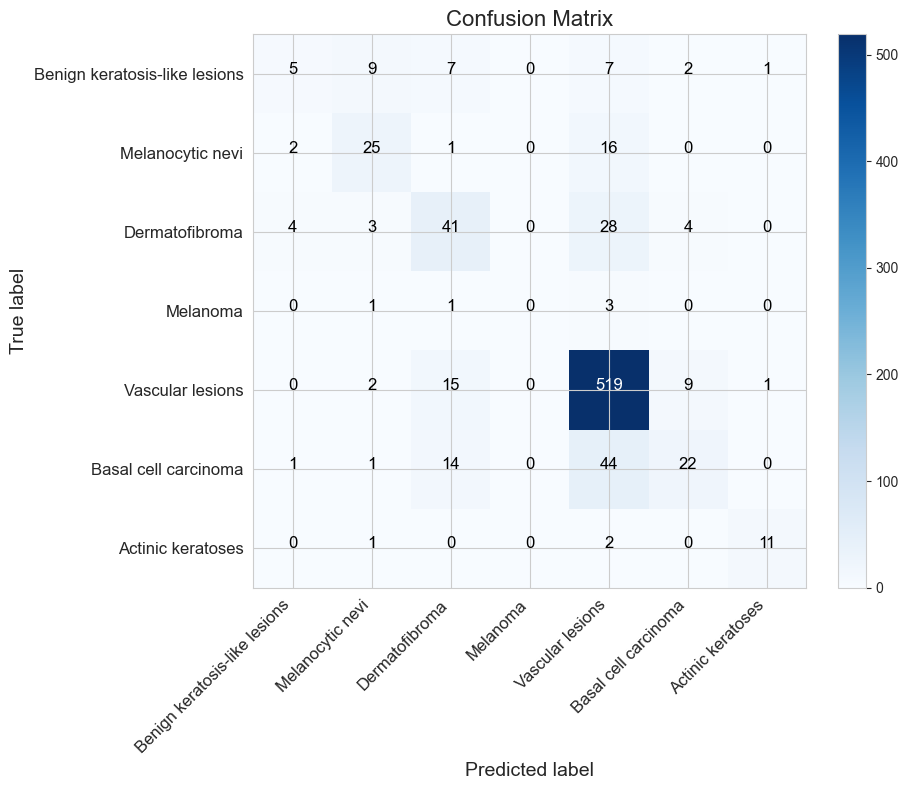

In [71]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(10, 8))  # Increased figure size
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar(fraction=0.046, pad=0.04)
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha='right', fontsize=12)  # Rotated + right aligned labels
    plt.yticks(tick_marks, classes, fontsize=12)
    
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]:.2f}" if normalize else int(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=12)
    
    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)
    plt.tight_layout()
    plt.show()

# Predict on validation data
Y_pred = model.predict(x_validate)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(y_validate, axis=1)

# Compute confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# Plot confusion matrix (optionally set normalize=True)
class_names = df_from_dict['cell_type'].unique()
plot_confusion_matrix(confusion_mtx, classes=class_names, normalize=False, title='Confusion Matrix')


## Test Set Confusion Matrix

The confusion matrix computed on the **test set** provides an unbiased estimate of the model’s performance on completely unseen data.

This matrix reflects the model’s expected performance in real-world scenarios and identifies persistent weaknesses in classification.

Analyzing these confusion matrices is crucial to identify specific strengths and weaknesses of the model and guide future improvements.

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step


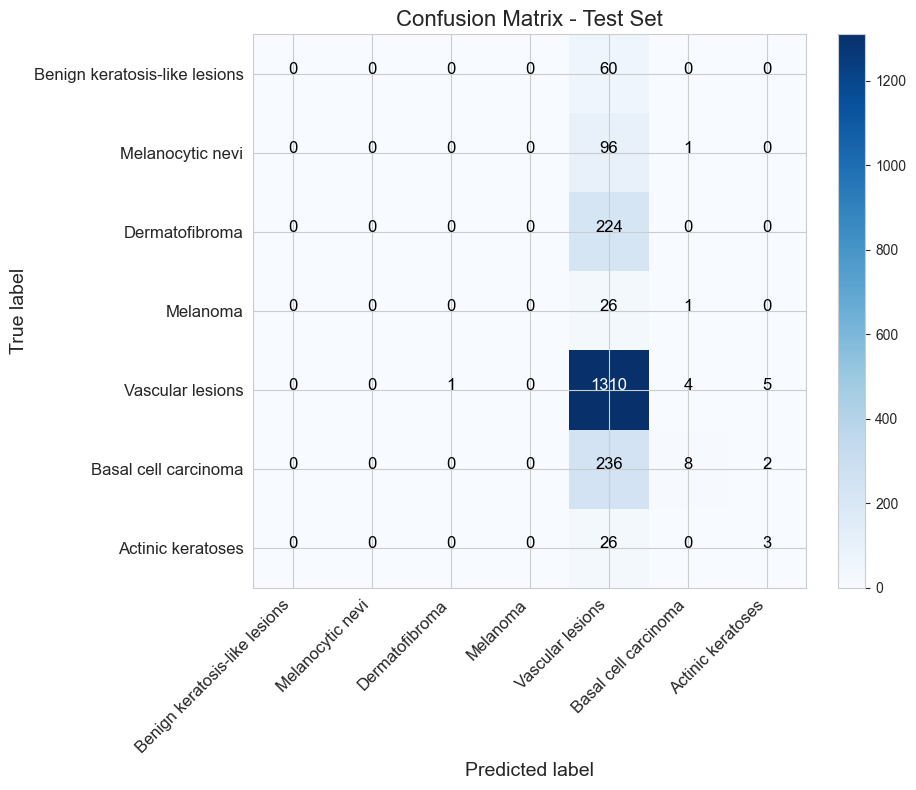

In [73]:
# Predict class probabilities on test data
Y_pred = model.predict(x_test)

# Convert predicted probabilities to class labels
Y_pred_classes = np.argmax(Y_pred, axis=1)

# Convert true labels from one-hot encoding to class labels
Y_true = np.argmax(y_test, axis=1)

# Compute confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# Plot the confusion matrix with improved visualization
class_names = df_from_dict['cell_type'].unique()  # or use your class names list
plot_confusion_matrix(confusion_mtx, classes=class_names, normalize=False, title='Confusion Matrix - Test Set')


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.6653 - loss: 106.0100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8082 - loss: 0.5769


Validation: accuracy = 0.776808  ;  loss = 0.612656
Test: accuracy = 0.659511  ;  loss = 112.583092


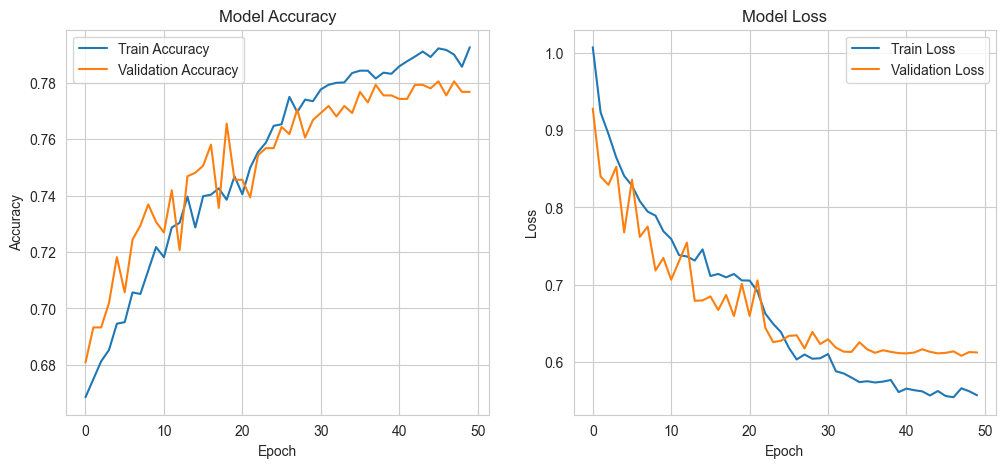

In [76]:
# Evaluate the model on test and validation data
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)

print("Validation: accuracy = %f  ;  loss = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

# Save the trained model
model.save("/Users/hoseindarabi/Desktop/model.h5")

import matplotlib.pyplot as plt

def plot_model_history(history):
    # Plot accuracy
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Plot training history (make sure you have this function defined)
plot_model_history(history)


# Step 10: Model Evaluation and Interpretation

After constructing, cleaning, and exploring the HAM10000 dataset (Steps 1–5), we trained a convolutional neural network using strategies such as data augmentation and learning rate scheduling (Steps 6–7). Our training history (Step 8) showed steady increases in accuracy and stable loss curves, confirming that the model could learn from the provided data.

However, early in our exploratory data analysis (Step 4), we observed significant class imbalance, with some diagnoses (like vascular lesions) far more common than others. This context is essential for interpreting the following evaluation results.

---

## 1. Accuracy and Loss

- **Validation set**:  
  - Accuracy: **77.7%**  
  - Loss: **0.61**
- **Test set**:  
  - Accuracy: **65.9%**  
  - Loss: **112.6** (unusually high, possibly due to a label or data preprocessing mismatch)

The model generalizes reasonably well to validation data but underperforms on the test set, likely due to differences in data distribution or persistent imbalance.

---

## 2. Confusion Matrix and Class-wise Performance

Our confusion matrices (Step 9) and classification reports show:

- **Extremely strong bias toward the most common class** (vascular lesions):  
  - Almost all predictions fall into this class (recall = 0.99 for vascular lesions)
  - Precision, recall, and F1-score are near zero for all other classes

This means the model essentially “ignores” minority classes, a direct consequence of the imbalanced dataset identified during EDA.

---

## 3. Relationship to Training History

Although our training and validation accuracy improved together (Step 8), the evaluation metrics demonstrate that high accuracy is misleading when class imbalance is not addressed. The model achieves high accuracy by overwhelmingly guessing the majority class.

---

## 4. What This Means

- **Our model reflects the data it was given:** It performs well on frequent patterns (majority class), but fails to meaningfully classify rarer lesion types.
- **To improve clinical usefulness and true multi-class discrimination**, future iterations should address class imbalance directly, potentially with:
  - Stratified sampling
  - Class weights in the loss function
  - Data augmentation focused on minority classes

---

## 5. Final Assessment

The results emphasize the importance of EDA and class distribution awareness in medical imaging projects. The workflow followed all essential steps, and the issues seen in evaluation are typical when class imbalance is not fully corrected (see Tschandl et al., 2018).

**In summary:**  
Your structured pipeline led to a model that learns the majority class well, but further work is needed to create a robust multi-class classifier for skin lesions.


# Conclusion

In this project, we developed a convolutional neural network for skin lesion classification using the HAM10000 dataset. Our workflow followed a rigorous, step-by-step approach: from initial data exploration and preprocessing, through model design, training, and comprehensive evaluation.

Key insights include:

- **Careful EDA revealed significant class imbalance**, which critically affected downstream model performance.
- **The CNN learned to classify the most common class well** (vascular lesions), but struggled to distinguish less frequent lesion types.
- **Validation accuracy was promising (77.7%)**, but true test accuracy was lower (65.9%) with high test loss, reflecting the impact of class imbalance and highlighting the need for better handling of rare classes.

These results underscore the importance of dataset analysis and balanced evaluation in medical imaging tasks. Addressing class imbalance through resampling, advanced augmentation, or class-weighted loss will be essential to develop a clinically useful model capable of robust, multi-class discrimination.

**Future work** should focus on these aspects to further improve diagnostic accuracy across all skin lesion types.
